In [2]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mesa


In [3]:
def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.agents]
    x = sorted(agent_wealths)
    n = model.num_agents
    B = sum(xi * (n - i) for i, xi in enumerate(x)) / (n * sum(x))
    return 1 + (1 / n) - 2 * B


class MoneyModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, n, width, height, seed=None):
        super().__init__(seed=seed)
        self.num_agents = n
        self.grid = mesa.space.MultiGrid(width, height, True)
        self.running = True

        # Create agents
        agents = MoneyAgent.create_agents(model=self, n=n)
        # Create x and y positions for agents
        x = self.rng.integers(0, self.grid.width, size=(n,))
        y = self.rng.integers(0, self.grid.height, size=(n,))
        for a, i, j in zip(agents, x, y):
            # Add the agent to a random grid cell
            self.grid.place_agent(a, (i, j))

        self.datacollector = mesa.DataCollector(
            model_reporters={"Gini": compute_gini},
            agent_reporters={"Wealth": "wealth", "Steps_not_given": "steps_not_given"},
        )

    def step(self):
        self.datacollector.collect(self)
        self.agents.shuffle_do("move")
        self.agents.shuffle_do("give_money")


class MoneyAgent(mesa.Agent):
    """An agent with fixed initial wealth."""

    def __init__(self, model):
        super().__init__(model)
        self.wealth = 1
        self.steps_not_given = 0

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos, moore=True, include_center=False
        )
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        cellmates.pop(cellmates.index(self))
        if len(cellmates) > 0 and self.wealth > 0:
            other = self.random.choice(cellmates)
            other.wealth += 1
            self.wealth -= 1
            self.steps_not_given = 0
        else:
            self.steps_not_given += 1

In [ ]:
params = {"width": 10, "height": 10, "n": range(5, 100, 5)}

results = mesa.batch_run(
    MoneyModel,
    parameters=params,
    iterations=5,
    max_steps=100,
    number_processes=1,
    data_collection_period=1,
    display_progress=True,
)


results_df = pd.DataFrame(results)
print(results_df.keys())

  0%|          | 0/95 [00:00<?, ?it/s]

In [5]:
results_df = pd.DataFrame(results)
print(results_df.keys())

Index(['RunId', 'iteration', 'Step', 'width', 'height', 'n', 'Gini', 'AgentID',
       'Wealth', 'Steps_not_given'],
      dtype='object')


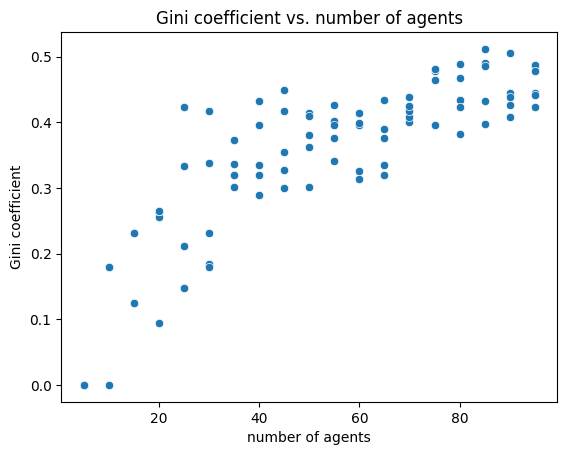

In [6]:
# Filter the results to only contain the data of one agent
# The Gini coefficient will be the same for the entire population at any time
results_filtered = results_df[(results_df.AgentID == 1) & (results_df.Step == 100)]
results_filtered[["iteration", "n", "Gini"]].reset_index(
    drop=True
).head()  # Create a scatter plot
g = sns.scatterplot(data=results_filtered, x="n", y="Gini")
g.set(
    xlabel="number of agents",
    ylabel="Gini coefficient",
    title="Gini coefficient vs. number of agents",
);

In [7]:
results_filtered

,RunId,iteration,Step,width,height,n,Gini,AgentID,Wealth,Steps_not_given
496,0,0,100,10,10,5,0.000000,1.0,1.0,29.0
1492,1,0,100,10,10,10,0.000000,1.0,1.0,0.0
2988,2,0,100,10,10,15,0.124444,1.0,1.0,18.0
4984,3,0,100,10,10,20,0.255000,1.0,1.0,2.0
7480,4,0,100,10,10,25,0.332800,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
440016,90,4,100,10,10,75,0.480711,1.0,0.0,1.0
448012,91,4,100,10,10,80,0.423125,1.0,0.0,5.0
456508,92,4,100,10,10,85,0.484983,1.0,1.0,0.0
465504,93,4,100,10,10,90,0.438025,1.0,2.0,3.0


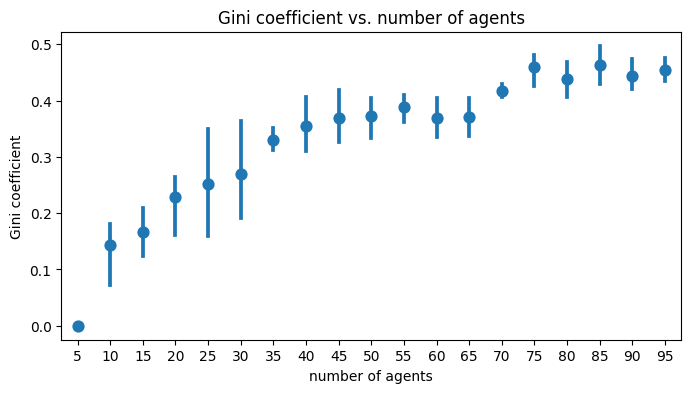

In [8]:
# Create a point plot with error bars
g = sns.pointplot(data=results_filtered, x='n', y="Gini", linestyle="None")
g.figure.set_size_inches(8, 4)
g.set(
    xlabel="number of agents",
    ylabel="Gini coefficient",
    title="Gini coefficient vs. number of agents",
);

In [9]:
# First, we filter the results
one_episode_wealth = results_df[(results_df.n == 10) & (results_df.iteration == 2)]
# Then, print the columns of interest of the filtered data frame
print(
    one_episode_wealth.to_string(
        index=False, columns=["Step", "AgentID", "Wealth"], max_rows=10
    )
)

 Step  AgentID  Wealth
    0      NaN     NaN
    1      1.0     1.0
    1      2.0     1.0
    1      3.0     1.0
    1      4.0     1.0
  ...      ...     ...
  100      6.0     1.0
  100      7.0     1.0
  100      8.0     1.0
  100      9.0     1.0
  100     10.0     1.0


In [10]:
results_one_episode = results_df[
    (results_df.n == 10) & (results_df.iteration == 1) & (results_df.AgentID == 1)
]
print(results_one_episode.to_string(index=False, columns=["Step", "Gini"], max_rows=10))

 Step  Gini
    1  0.00
    2  0.00
    3  0.00
    4  0.00
    5  0.00
  ...   ...
   96  0.18
   97  0.18
   98  0.18
   99  0.18
  100  0.18


In [11]:
results_one_episode

,RunId,iteration,Step,width,height,n,Gini,AgentID,Wealth,Steps_not_given
95521,20,1,1,10,10,10,0.00,1.0,1.0,0.0
95531,20,1,2,10,10,10,0.00,1.0,1.0,1.0
95541,20,1,3,10,10,10,0.00,1.0,1.0,2.0
95551,20,1,4,10,10,10,0.00,1.0,1.0,0.0
95561,20,1,5,10,10,10,0.00,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...
96471,20,1,96,10,10,10,0.18,1.0,1.0,25.0
96481,20,1,97,10,10,10,0.18,1.0,1.0,26.0
96491,20,1,98,10,10,10,0.18,1.0,1.0,27.0
96501,20,1,99,10,10,10,0.18,1.0,1.0,28.0


In [12]:
params = {"seed": None, "width": 10, "height": 10, "n": [5, 10, 20, 40, 80]}

results_5s = mesa.batch_run(
    MoneyModel,
    parameters=params,
    iterations=25,
    max_steps=100,
    number_processes=1,
    data_collection_period=1,  # Need to collect every step
    display_progress=True,
)

results_5s_df = pd.DataFrame(results_5s)

  0%|          | 0/125 [00:00<?, ?it/s]

In [23]:
# Again filter the results to only contain the data of one agent
# The Gini coefficient will be the same for the entire population at any time.
results_5s_df_filtered = results_5s_df[(results_5s_df.AgentID == 1)]
results_5s_df_filtered.head(3)

,RunId,iteration,Step,seed,width,height,n,Gini,AgentID,Wealth,Steps_not_given
1,0,0,1,None,10,10,5,0.0,1.0,1.0,0.0
6,0,0,2,None,10,10,5,0.0,1.0,1.0,1.0
11,0,0,3,None,10,10,5,0.0,1.0,1.0,2.0


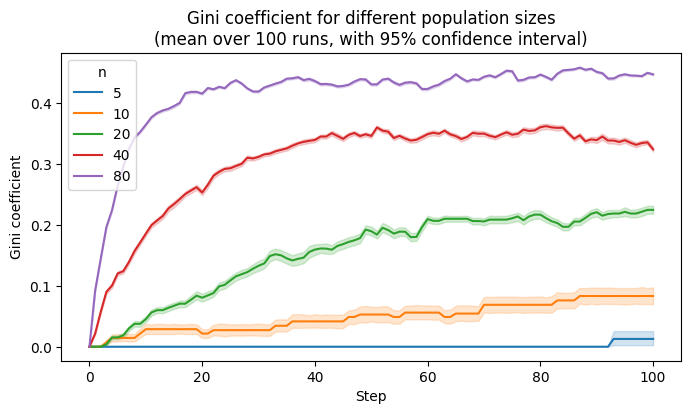

In [13]:
# Create a lineplot with error bars
g = sns.lineplot(
    data=results_5s_df,
    x="Step",
    y="Gini",
    hue="n",
    errorbar=("ci", 95),
    palette="tab10",
)
g.figure.set_size_inches(8, 4)
plot_title = (
    "Gini coefficient for different population sizes\n"
    "(mean over 100 runs, with 95% confidence interval)"
)
g.set(title=plot_title, ylabel="Gini coefficient");

In [25]:
# Calculate the mean of the wealth and the number of consecutive rounds
# for all agents in each episode.
agg_results_df = (
    results_5s_df.groupby(["iteration", "n", "Step"])
    .agg({"Wealth": "mean", "Steps_not_given": "mean"})
    .reset_index()
)
agg_results_df.head(3)

,iteration,n,Step,Wealth,Steps_not_given
0,0,5,0,NaN,NaN
1,0,5,1,1.0,0.0
2,0,5,2,1.0,1.0


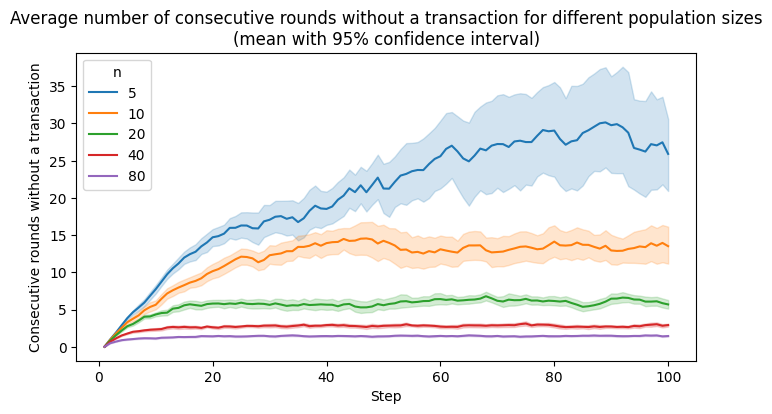

In [26]:
# Create a line plot with error bars
g = sns.lineplot(
    data=agg_results_df, x="Step", y="Steps_not_given", hue="n", palette="tab10"
)
g.figure.set_size_inches(8, 4)
g.set(
    title="Average number of consecutive rounds without a transaction for "
    "different population sizes\n(mean with 95% confidence interval)",
    ylabel="Consecutive rounds without a transaction",
);